# Market Average Price Research

### Juliana Kennedy, March 9, 2019

This notebook uses active inventory available in states that Lithia Dealerships are in or are adjacent to.  I'm using this source in lieu of Market Listings for testing purposes.



In [1]:
# import requisite libraries
import requests
import pandas as pd
import csv
import numpy as np
from sklearn.cross_validation import train_test_split #this will soon be deprecated

#Replace viz libraries with Plotly
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from pylab import rcParams


C:\Users\julia\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_csv('sample.csv')
df.columns
# df['class']

Index(['ParentBusinessUnit', 'BusinessUnit', 'Latitude', 'Longitude',
       'StateShort', 'Year', 'Make', 'Model', 'Trim', 'Mileage', 'ListPrice',
       'LotPrice', 'MSRP', 'MarketAveragePrice', 'AgeInDays', 'Color',
       'InteriorColor', 'ReconditionCost', 'UnitCost', 'PotentialGross',
       'Stock', 'VIN', 'Received', 'Transmission', 'Risk', 'PrimaryBookValue',
       'class'],
      dtype='object')

## Munging

The Class series is the concatenation of Drive Train, Doors, and Class (in no particular order).  For simplicity's sake, I am going to use regex to parse the values out to individual components we can use in our analysis.
* MakeModel = Concatenation of Make and Model
* DriveTrain = Parsed from Class
* Doors = Parsed from Class
* Class = Class with Doors and DriveTrain removed

    

In [3]:
# Lets use regex to find the patterns we want to parse from the class series
import re

# Define patterns for DriveTrain and Doors
dt_pat = r"[0-9][W][D]"
d_pat = r"[0-9][\-]door"

# concatenate MakeModel
df['MakeModel'] = df['Make'].str.cat(df['Model'], sep = ' ')

# make YMM
df['YMM'] = df.Year.map(str) + ' '+ df.MakeModel



# Find all DriveTrain and Door values
df['DriveTrain']= df['class'].str.findall(dt_pat)
df['Doors'] = df['class'].str.findall(d_pat)

# Flatten these new series of lists
df['DriveTrain']= df['DriveTrain'].apply(pd.Series).stack().reset_index(drop=True)
df['Doors']= df['Doors'].apply(pd.Series).stack().reset_index(drop=True)

# Strip DriveTrain and Door values from class and make a new series Class
df['Class'] = df['class'].str.replace(dt_pat, '', n=-1, case=None, flags=1, regex=True)
df['Class'] = df['Class'].str.replace(d_pat, '', n=-1, case=None, flags=1, regex=True)

In [4]:
df.head(2)

,ParentBusinessUnit,BusinessUnit,Latitude,Longitude,StateShort,Year,Make,Model,Trim,Mileage,...,Received,Transmission,Risk,PrimaryBookValue,class,MakeModel,YMM,DriveTrain,Doors,Class
0,Lithia Motors Inc.,Klamath Falls Toyota,42.2076,-121.7547,OR,2001,Dodge,Ram 2500,NaN,300891.0,...,3/3/2019,Manual,RED,5102.0,2WD Standard Pickup Trucks,Dodge Ram 2500,2001 Dodge Ram 2500,2WD,4-door,Standard Pickup Trucks
1,Lithia Motors Inc.,Klamath Falls Toyota,42.2076,-121.7547,OR,2016,Ford,Escape,SE,54270.0,...,1/18/2019,Automatic,YELLOW,13949.0,4WD Sport Utility Vehicles,Ford Escape,2016 Ford Escape,4WD,4-door,Sport Utility Vehicles


In [5]:
print(df.Make.nunique())
print(df.MakeModel.nunique())
print(df.YMM.nunique())

51
625
2747


## Price Distribution by Model Year

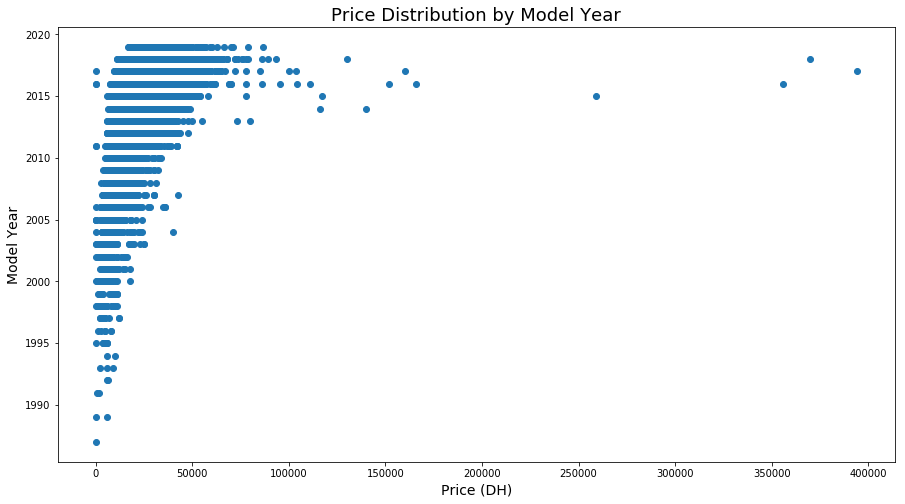

In [6]:
# here we set the figure size to 15x8
plt.figure(figsize=(15, 8))  # eh.  i don't care

# plot two values price per year_model
plt.scatter(df.ListPrice, df.Year)
plt.xlabel("Price (DH)", fontsize=14)
plt.ylabel("Model Year", fontsize=14)
plt.title("Price Distribution by Model Year",fontsize=18)
plt.show()

## Price Distribution by Make

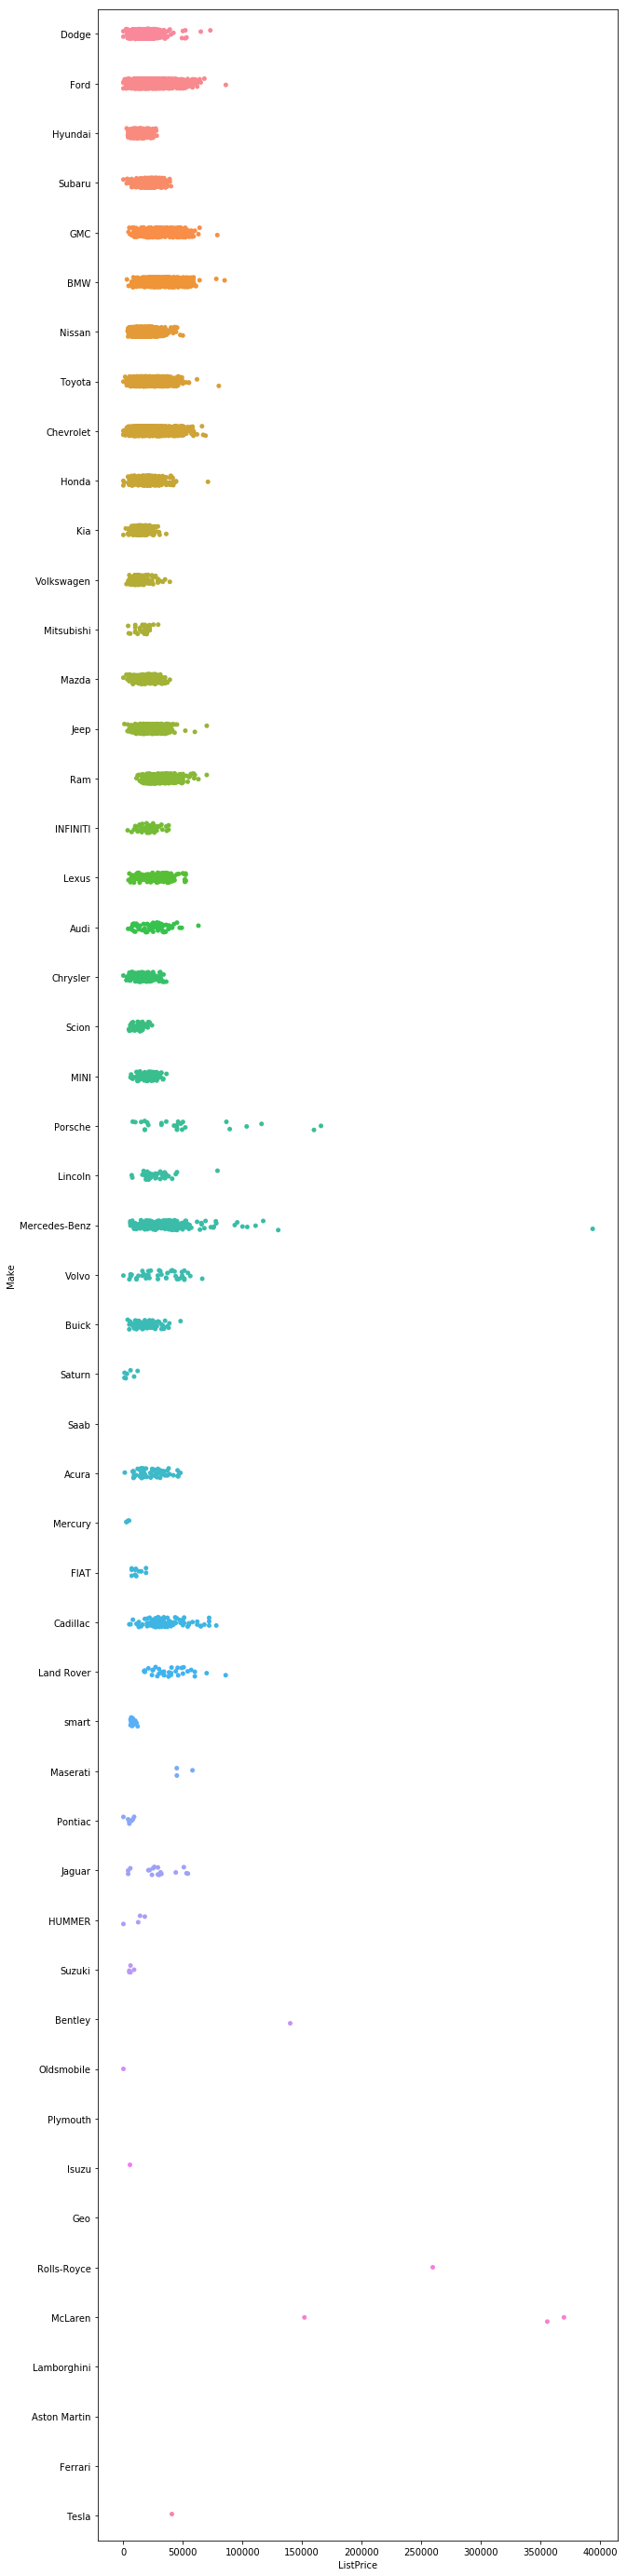

In [7]:
f, ax = plt.subplots(figsize=(10, 50))
sns.stripplot(data = df, x='ListPrice', y='Make', jitter=.1)
plt.show()

### What does it mean???  Not a whole lot!

From the plot above, we can extract some the following insights :

Hyundai, KIA, smart, and Scion (are they still around??) had very compact ranges of price which means that they are not very diversified in terms of price by model.  

The majority of makes have a broad price range.  Contributing factors could be:
* Mileage
* Vehicle Year
* Model
* Trim
* Class

As we include these factors, we should see each grouping become more compact thus limiting the price range.  Lets normalize the data so that YMM is a single value for simplid

## Linear Regression Plot - ListPrice vs Mileage

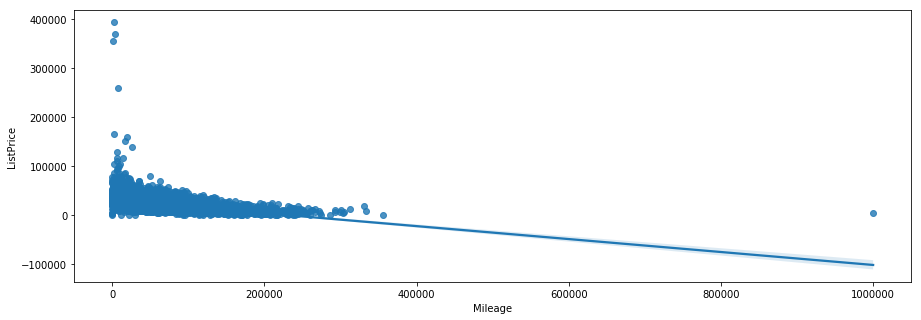

In [8]:

f, ax = plt.subplots(figsize=(15, 5))
sns.regplot(data=df, x= 'Mileage', y = 'ListPrice', truncate=True)
plt.show()

## Top 20 Makes

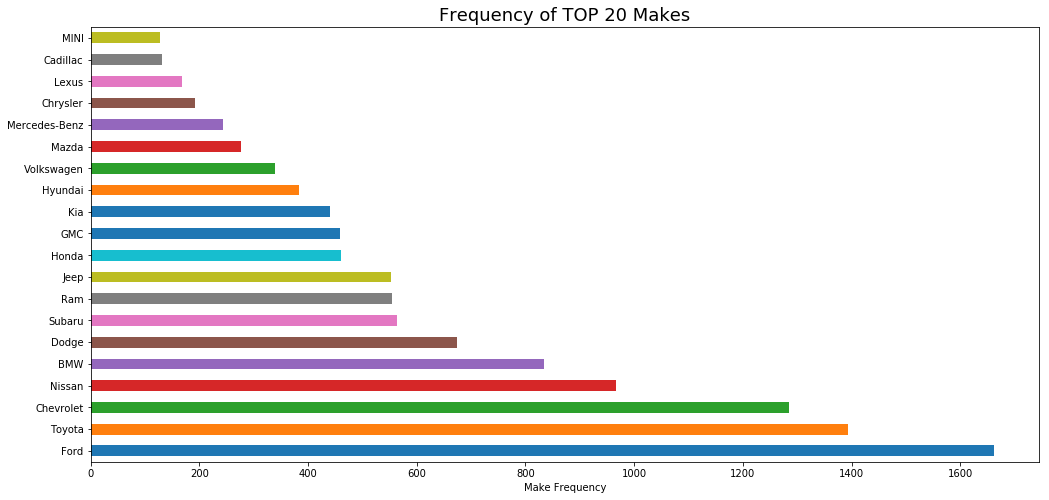

In [9]:
plt.figure(figsize=(17,8))
df.Make.value_counts().nlargest(20).plot(kind='barh')
plt.xlabel('Make Frequency')
plt.title("Frequency of TOP 20 Makes",fontsize=18)
plt.show()

In [10]:
# df.columns

## Distribution by YMM

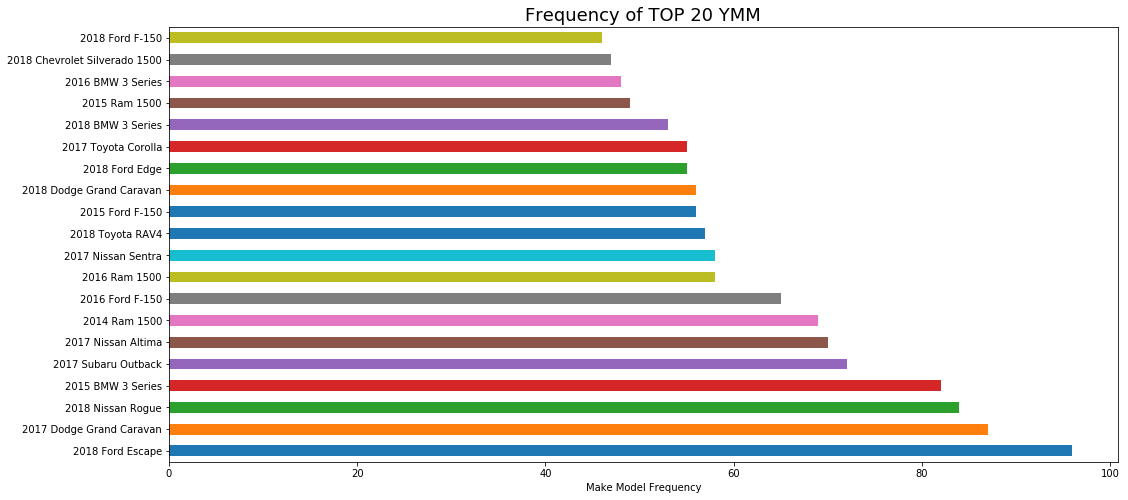

In [11]:
plt.figure(figsize=(17,8))
df.YMM.value_counts().nlargest(20).plot(kind='barh')
plt.xlabel('Make Model Frequency')
plt.title("Frequency of TOP 20 YMM",fontsize=18)
plt.show()

### Insights

The most common YMMs here are not in the set of Makes that had the most compact pricing ranges.  So what else can we add in?

* Trim
* Mileage
* AgeInDays
* Color
* Transmission
* DriveTrain
* Doors
* Class

## Correlations in the Data

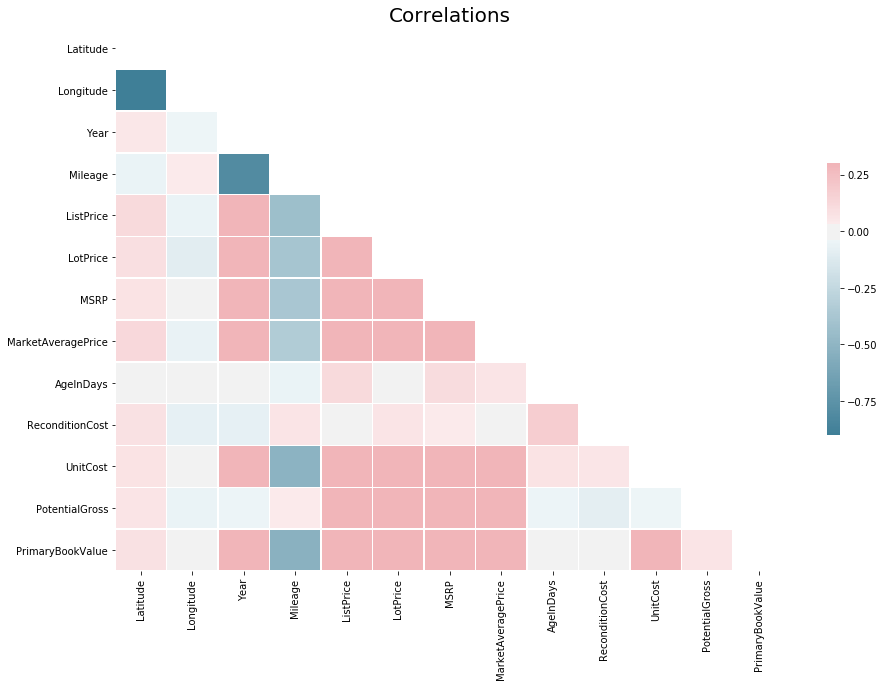

In [14]:
# Generate a custom diverging colormap
cmap = sns.diverging_palette(225, 10, as_cmap=True)
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 10))
# Compute the correlation matrix
corr = df.corr()

#print(corr)
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=False, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlations', 
          fontsize = 20)
plt.show()

In [15]:
# Correlation Values.  Values closest to 1 greater correlation (duh)
print(corr)

                    Latitude  Longitude      Year   Mileage  ListPrice  \
Latitude            1.000000  -0.900217  0.049273 -0.053754   0.114469   
Longitude          -0.900217   1.000000 -0.039836  0.033357  -0.052430   
Year                0.049273  -0.039836  1.000000 -0.803273   0.430744   
Mileage            -0.053754   0.033357 -0.803273  1.000000  -0.434913   
ListPrice           0.114469  -0.052430  0.430744 -0.434913   1.000000   
LotPrice            0.096418  -0.094310  0.410281 -0.391507   0.969666   
MSRP                0.073341   0.016230  0.382630 -0.379764   0.891873   
MarketAveragePrice  0.117817  -0.063725  0.376687 -0.337054   0.962772   
AgeInDays           0.020307   0.021113 -0.012655 -0.056180   0.116437   
ReconditionCost     0.083314  -0.078867 -0.073075  0.062731   0.007933   
UnitCost            0.072253  -0.020065  0.512595 -0.514095   0.862975   
PotentialGross      0.063536  -0.054417 -0.049474  0.033526   0.470366   
PrimaryBookValue    0.080397  -0.02123

# Models
## KNN Regression

K-Nearest Neighbors can be used for both classification and regression problems.  

KNN can be equally effective when the target variable is continuous in nature. # maybe toos

The algorithm uses ‘feature similarity’ to predict values of any new data points. This means that the new point is assigned a value based on how closely it resembles the points in the training set.



In [25]:
# What are the average ListPrices for each YMM Combination?

YMM_df = df.groupby(['YMM', 'Trim', 'DriveTrain', 'Class', 'Longitude', 'Latitude']).mean()
#Dropping NULLs from the DF
YMM_df.dropna(inplace=True)
YMM_df.to_csv ('meansbygrouping.csv')

In [28]:
df_trim = df[df.ListPrice < 200000]


In [29]:
# This drop ~2.4K record that could skew training.
print(len(df))
print(len(df_trim))

12489
10070


In [30]:
df_trim.head()

,ParentBusinessUnit,BusinessUnit,Latitude,Longitude,StateShort,Year,Make,Model,Trim,Mileage,...,Received,Transmission,Risk,PrimaryBookValue,class,MakeModel,YMM,DriveTrain,Doors,Class
0,Lithia Motors Inc.,Klamath Falls Toyota,42.2076,-121.7547,OR,2001,Dodge,Ram 2500,NaN,300891.0,...,3/3/2019,Manual,RED,5102.0,2WD Standard Pickup Trucks,Dodge Ram 2500,2001 Dodge Ram 2500,2WD,4-door,Standard Pickup Trucks
1,Lithia Motors Inc.,Klamath Falls Toyota,42.2076,-121.7547,OR,2016,Ford,Escape,SE,54270.0,...,1/18/2019,Automatic,YELLOW,13949.0,4WD Sport Utility Vehicles,Ford Escape,2016 Ford Escape,4WD,4-door,Sport Utility Vehicles
2,Lithia Motors Inc.,Klamath Falls Toyota,42.2076,-121.7547,OR,2013,Hyundai,Sonata,GLS PZEV,105515.0,...,12/21/2018,Automatic,RED,6859.0,4-door Mid-Size Passenger Car,Hyundai Sonata,2013 Hyundai Sonata,4WD,4-door,Mid-Size Passenger Car
4,Lithia Motors Inc.,Klamath Falls Toyota,42.2076,-121.7547,OR,2010,GMC,Sierra 1500,SLT,121054.0,...,6/21/2018,Automatic,RED,16568.0,4WD Standard Pickup Trucks,GMC Sierra 1500,2010 GMC Sierra 1500,4WD,4-door,Standard Pickup Trucks
6,Lithia Motors Inc.,Klamath Falls Toyota,42.2076,-121.7547,OR,2017,Ford,Super Duty F-350 SRW,LARIAT,16590.0,...,12/18/2018,Automatic,YELLOW,60104.0,4WD Standard Pickup Trucks,Ford Super Duty F-350 SRW,2017 Ford Super Duty F-350 SRW,4WD,4-door,Standard Pickup Trucks


###### Categorize

Dealing with Categorical Features
At the moment we still have 3 categorical features which are the fuel_type, mark and model the aim of this section is to pre process those features in order to make them numerical so that they will fit into our model.

Explain label encoding and hot encoding.  This is hot encoding

In [31]:
X = df_trim[['Year', 'Make', 'Model', 'Trim', 'DriveTrain', 'Class']]
Y = df_trim.ListPrice
X = pd.get_dummies(data=X)

In [32]:
X.head()

,Year,Make_Acura,Make_Audi,Make_BMW,Make_Bentley,Make_Buick,Make_Cadillac,Make_Chevrolet,Make_Chrysler,Make_Dodge,...,Class_Cargo Vans,Class_Commercial Vehicles,Class_Large Passenger Vans,Class_Large Wagon,Class_Luxury,Class_Mid-Size Wagon,Class_Midsize,Class_Mini-Van (Passenger),Class_Small Wagon,Class_Two-seater Passenger Car
0,2001,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,2016,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2013,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2010,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2017,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
#splitting

In [34]:
# now we use the train_test_split function already available in sklearn library to split our data set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .20, random_state = 42)

C:\Users\julia\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


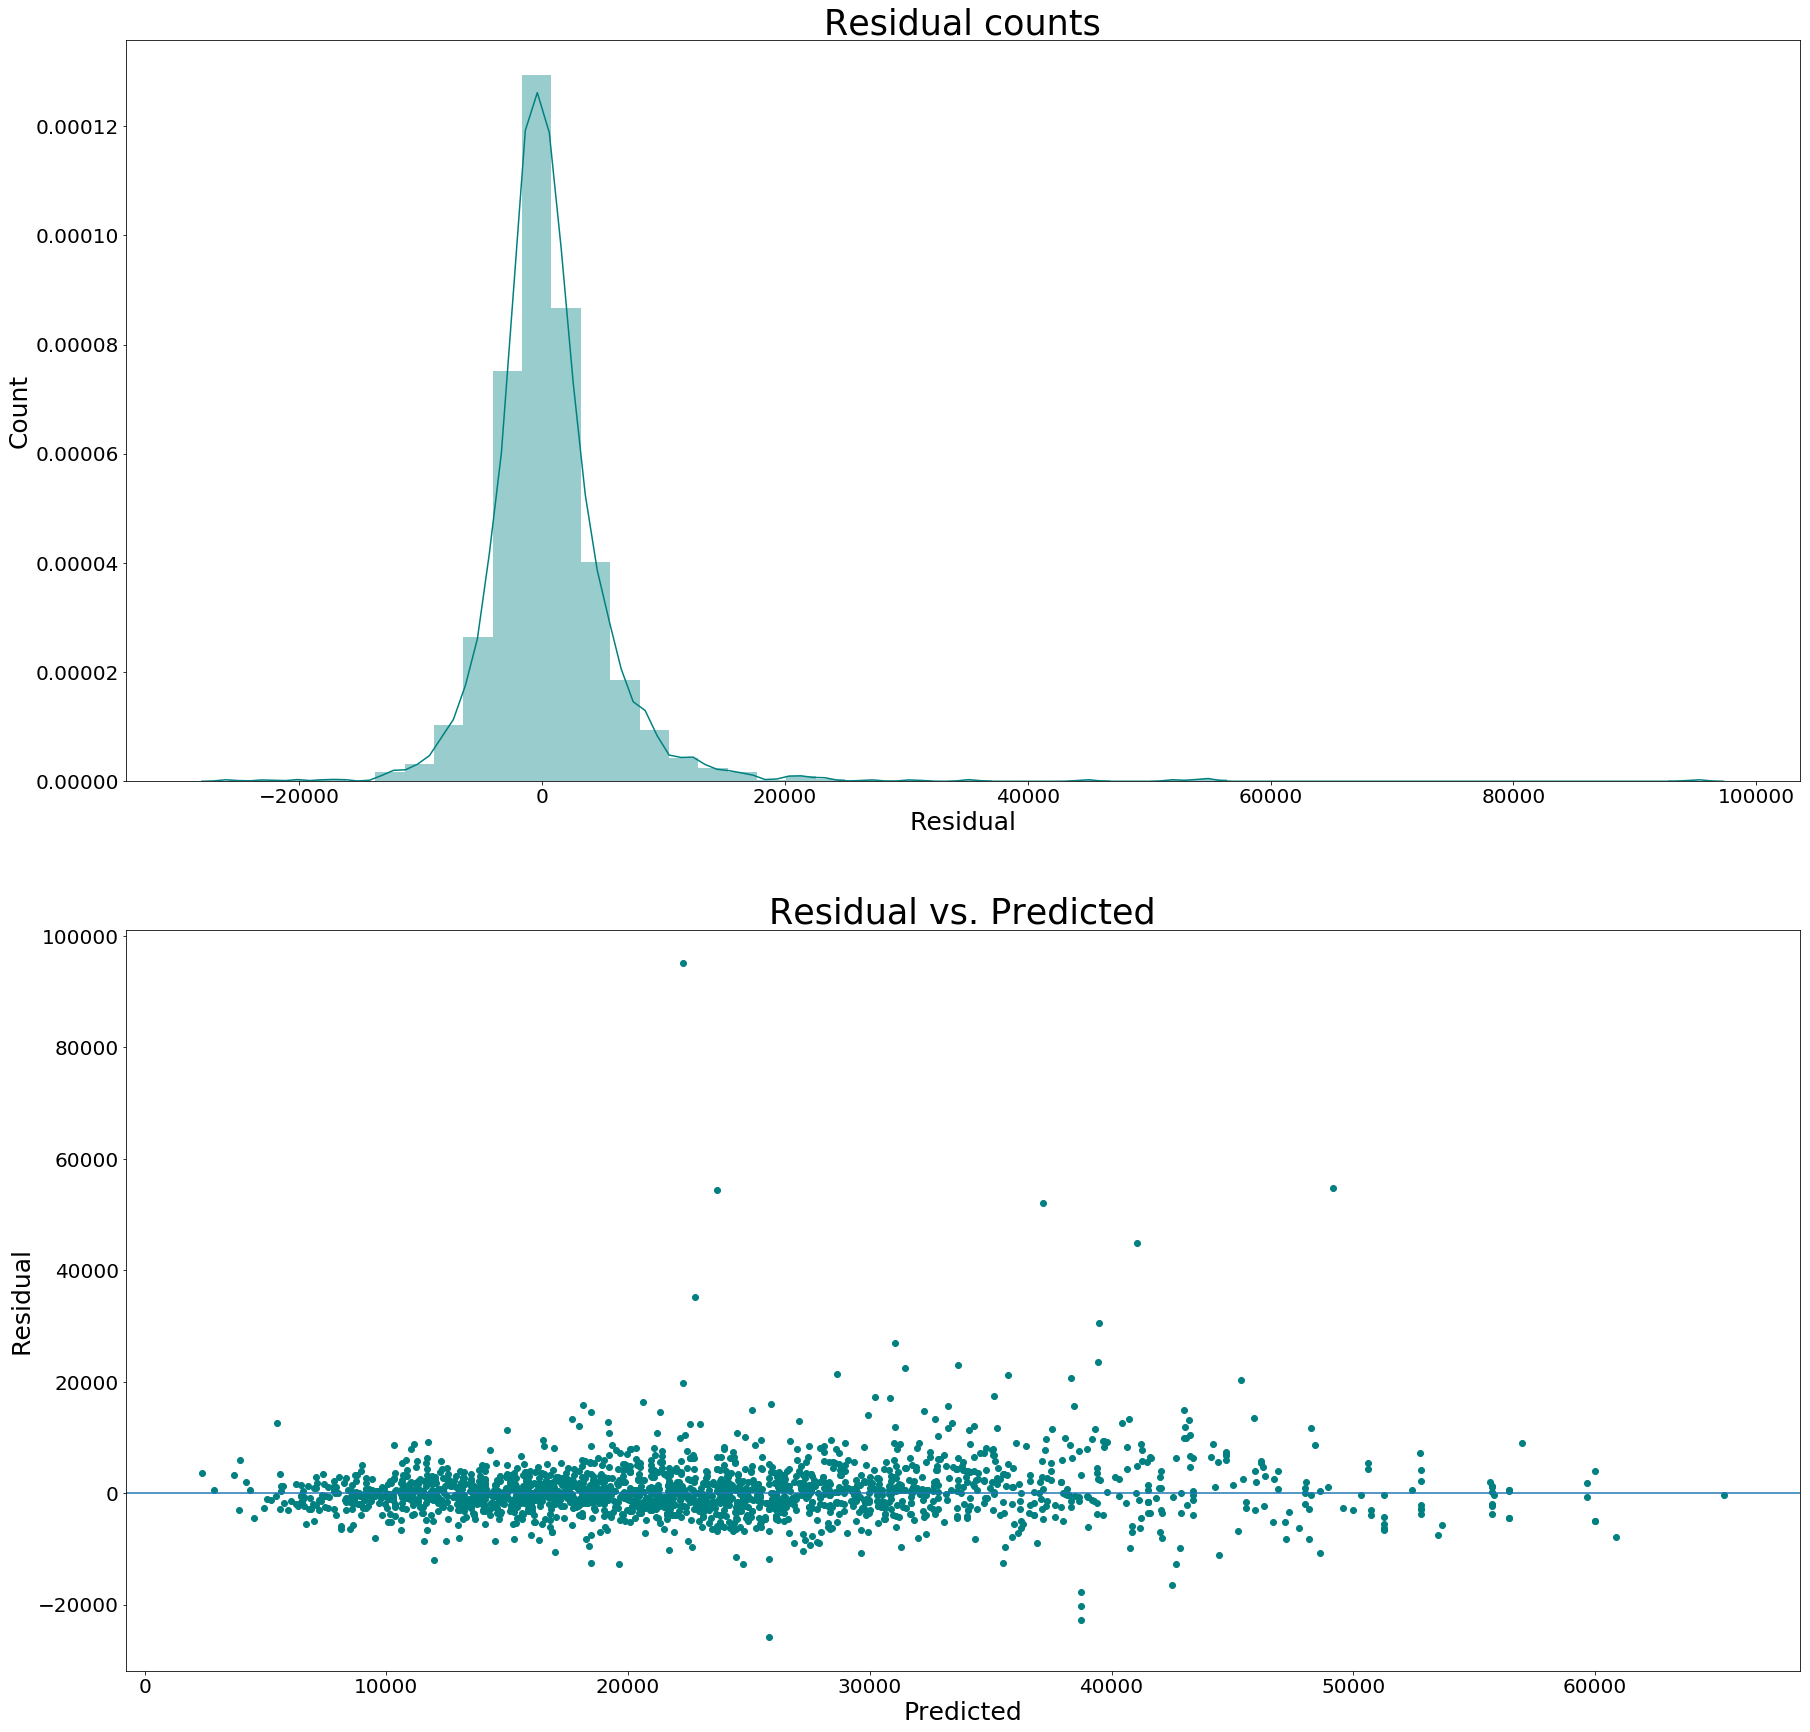

RMSE:
5508.242817095712


In [35]:
from sklearn import neighbors
# the value of n_neighbors will be changed when we plot the histogram showing the lowest RMSE value
knn = neighbors.KNeighborsRegressor(n_neighbors=6)
knn.fit(X_train, Y_train)

predicted = knn.predict(X_test)
residual = Y_test - predicted

fig = plt.figure(figsize=(30,30))
ax1 = plt.subplot(211)
sns.distplot(residual, color ='teal')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Residual counts',fontsize=35)
plt.xlabel('Residual',fontsize=25)
plt.ylabel('Count',fontsize=25)

ax2 = plt.subplot(212)
plt.scatter(predicted, residual, color ='teal')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Predicted',fontsize=25)
plt.ylabel('Residual',fontsize=25)
plt.axhline(y=0)
plt.title('Residual vs. Predicted',fontsize=35)

plt.show()



## Terms
### RMSE
Root Mean Square Error (RMSE) measures how much error there is between two data sets. In other words, it compares a predicted value and an observed or known value.  The smaller this number, the better

### R-Squared Score
In regression, the R2 coefficient of determination is a statistical measure of how well the regression predictions approximate the real data points. An R2 of 1 indicates that the regression predictions perfectly fit the data.

In [37]:

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(Y_test, predicted))
print('RMSE:')
print(rmse)

from sklearn.metrics import r2_score
print('Variance score: %.2f' % r2_score(Y_test, predicted))

RMSE:
5508.242817095712
Variance score: 0.80


By specifying 6 n_neighbors, we have yielded a R2 score of 0.80.  Since the n_neighbors was an arbitrary value, I don't know if this is a good value.  I'll plot the same histogram above but with n_neighbors set by using the neighbors.KNeighborRegressor function with a range between 2 and 16.

We want to evaluate whether or not the RMSE is lower for either. # What about overfitting


In [38]:
rmse_l = []
num = []
for n in range(2, 16):
    knn = neighbors.KNeighborsRegressor(n_neighbors=n)
    knn.fit(X_train, Y_train)
    predicted = knn.predict(X_test)
    rmse_l.append(np.sqrt(mean_squared_error(Y_test, predicted)))
    num.append(n)

In [42]:
print(knn)
print(rmse_l)
print('Variance score: %.2f' % r2_score(Y_test, predicted))

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=15, p=2,
          weights='uniform')
[5142.582009234088, 5263.678449015566, 5407.479216138557, 5413.801321836054, 5508.242817095712, 5568.911856658482, 5670.35798198561, 5735.896099214723, 5786.51900322613, 5843.930077692286, 5863.668826466953, 5920.724783404364, 5949.109490270434, 5944.790441454258]
Variance score: 0.77


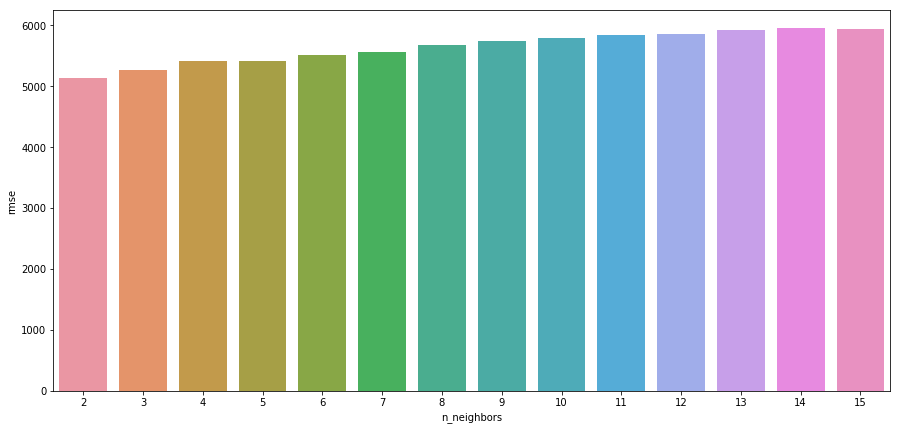

In [43]:
df_plt = pd.DataFrame()
df_plt['rmse'] = rmse_l
df_plt['n_neighbors'] = num
ax = plt.figure(figsize=(15,7))
sns.barplot(data = df_plt, x = 'n_neighbors', y = 'rmse')
plt.show()

## KNN Interpretation

# Decision Tree Model

C:\Users\julia\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


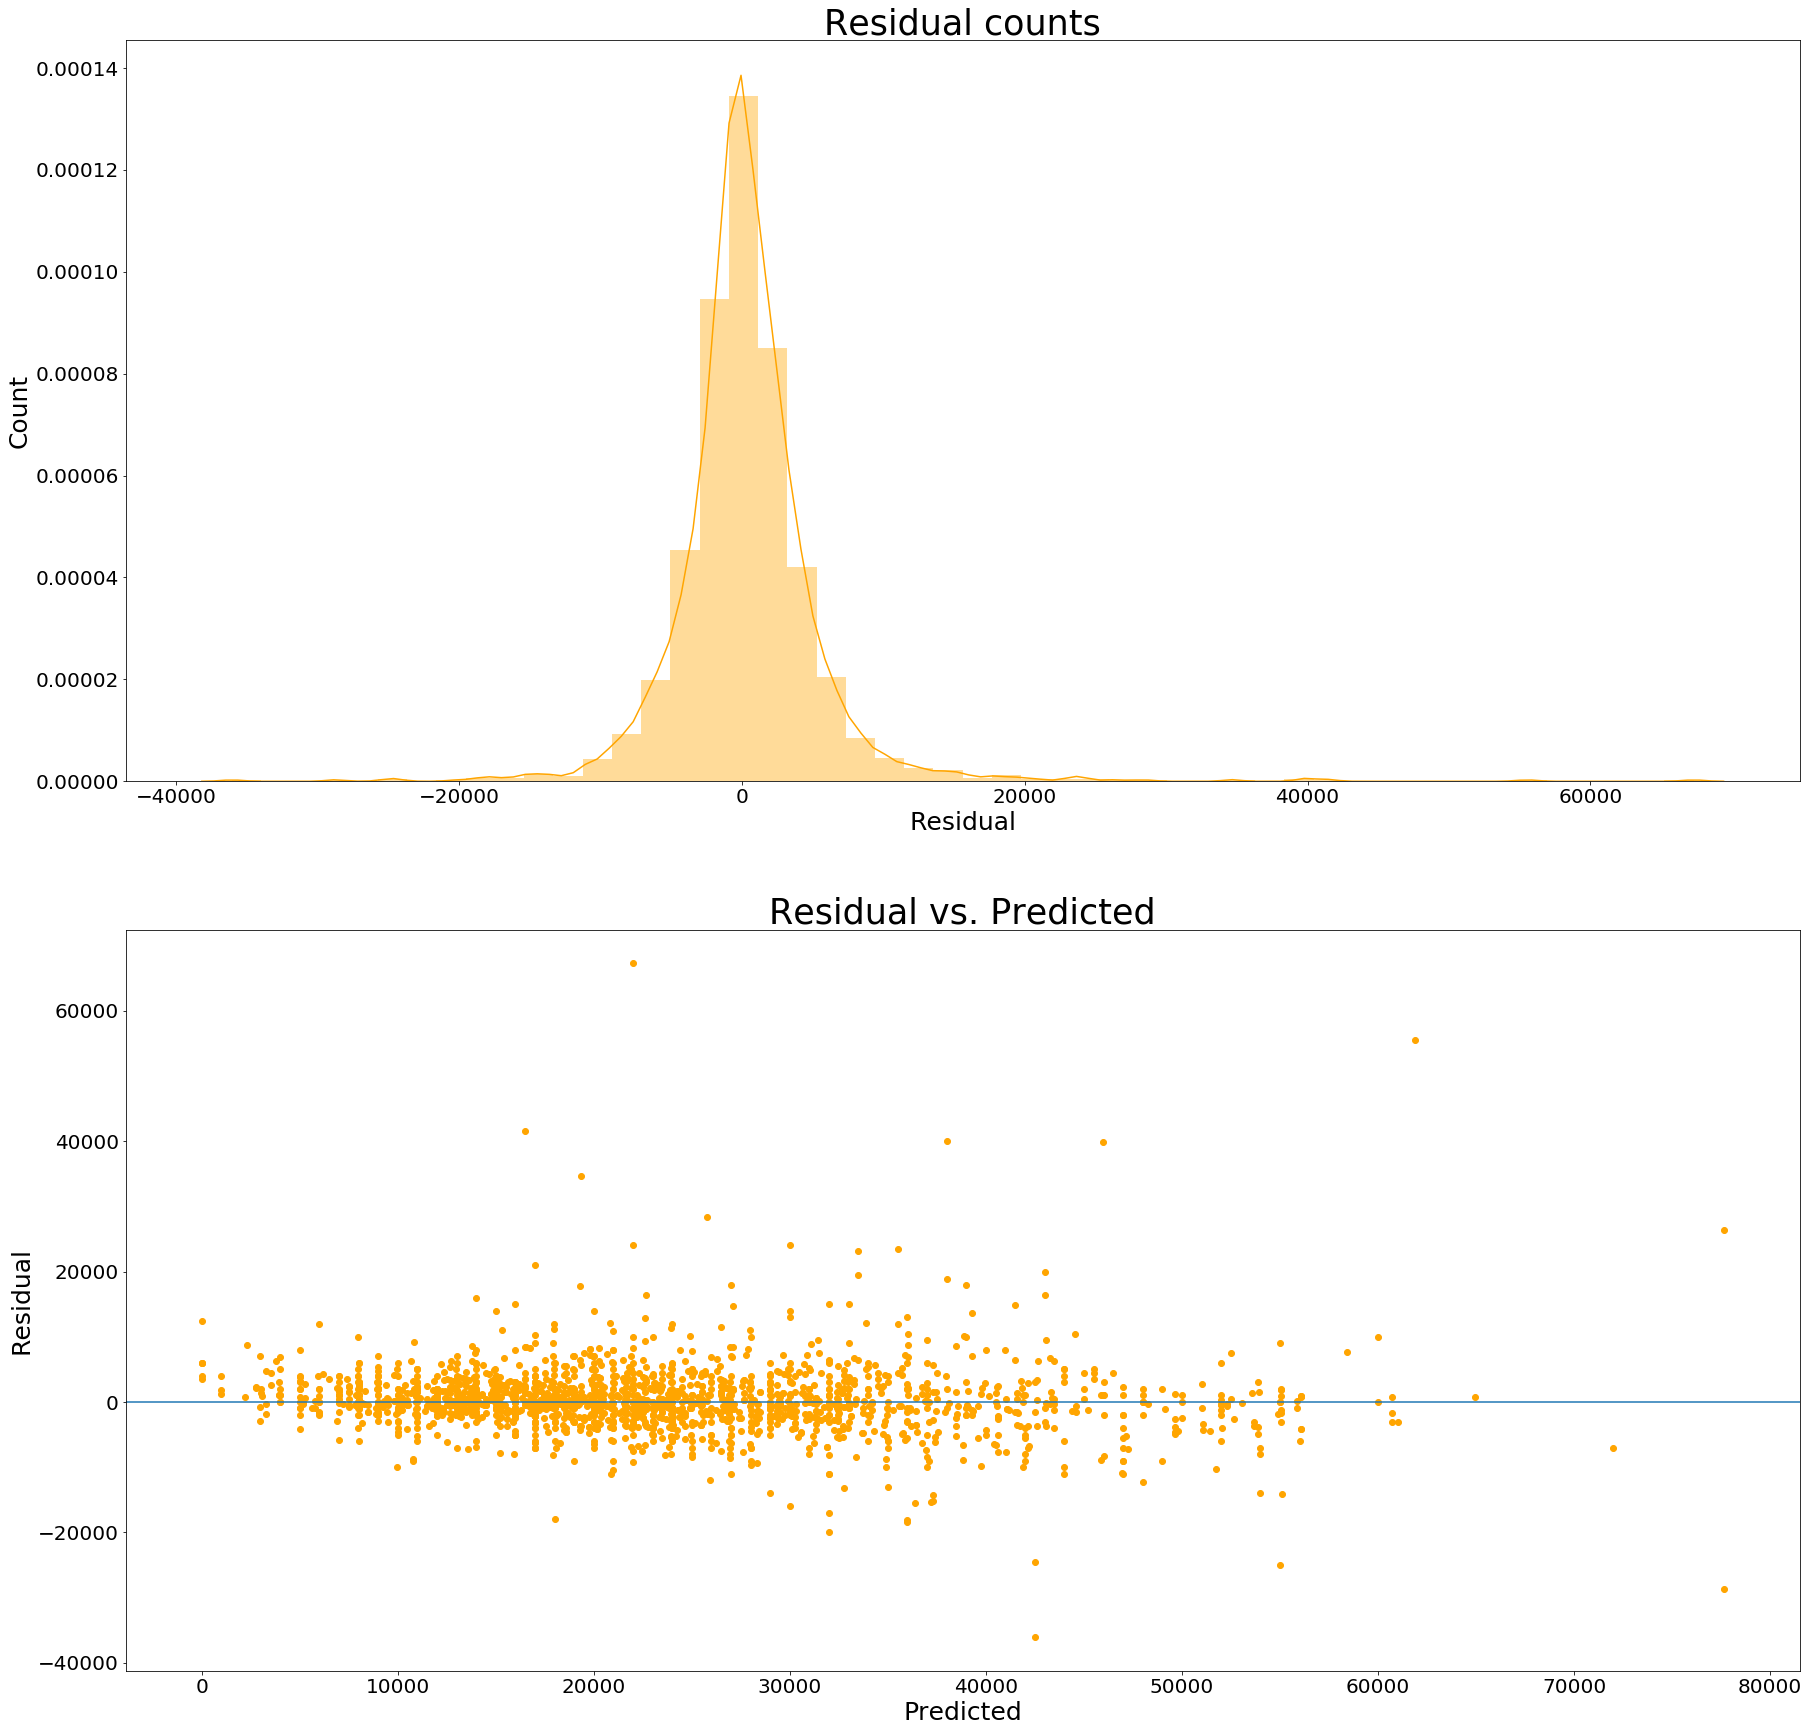

In [46]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(max_features='auto')
dtr.fit(X_train, Y_train)
predicted = dtr.predict(X_test)
residual = Y_test - predicted

fig = plt.figure(figsize=(30,30))
ax1 = plt.subplot(211)
sns.distplot(residual, color ='orange')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Residual counts',fontsize=35)
plt.xlabel('Residual',fontsize=25)
plt.ylabel('Count',fontsize=25)

ax2 = plt.subplot(212)
plt.scatter(predicted, residual, color ='orange')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Predicted',fontsize=25)
plt.ylabel('Residual',fontsize=25)
plt.axhline(y=0)
plt.title('Residual vs. Predicted',fontsize=35)

plt.show()



In [47]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(Y_test, predicted))
print('RMSE:')
print(rmse)
print('Variance score: %.2f' % r2_score(Y_test, predicted))







RMSE:
5298.616396310058
Variance score: 0.81


The root-mean-square deviation (RMSD) or root-mean-square error (RMSE) (or sometimes root-mean-squared error) is a frequently used measure of the differences between values (sample and population values) predicted by a model or an estimator and the values actually observed. The RMSD represents the sample standard deviation of the differences between predicted values and observed values. These individual differences are called residuals when the calculations are performed over the data sample that was used for estimation, and are called prediction errors when computed out-of-sample. The RMSD serves to aggregate the magnitudes of the errors in predictions for various times into a single measure of predictive power. RMSD is a measure of accuracy, to compare forecasting errors of different models for a particular data and not between datasets, as it is scale-dependent. ~ WikiPedia
By comparing the Tree Regression with the KNN Regression we can see that the RMSE was reduced from 37709 to 34392 which let us say that this model is more accurate than the last one, but that's not all of it, we still have to test other regression algorithm to check if there is any improvement in result.

Interpretation
By looking at the last RMSE score we've vast improvements, as you can see from the "Residual vs. Predicted" that the predicted score is closer to zero and is tighter around the lines which means that we are guessing alot closer to the price.

## Linear Regression

C:\Users\julia\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


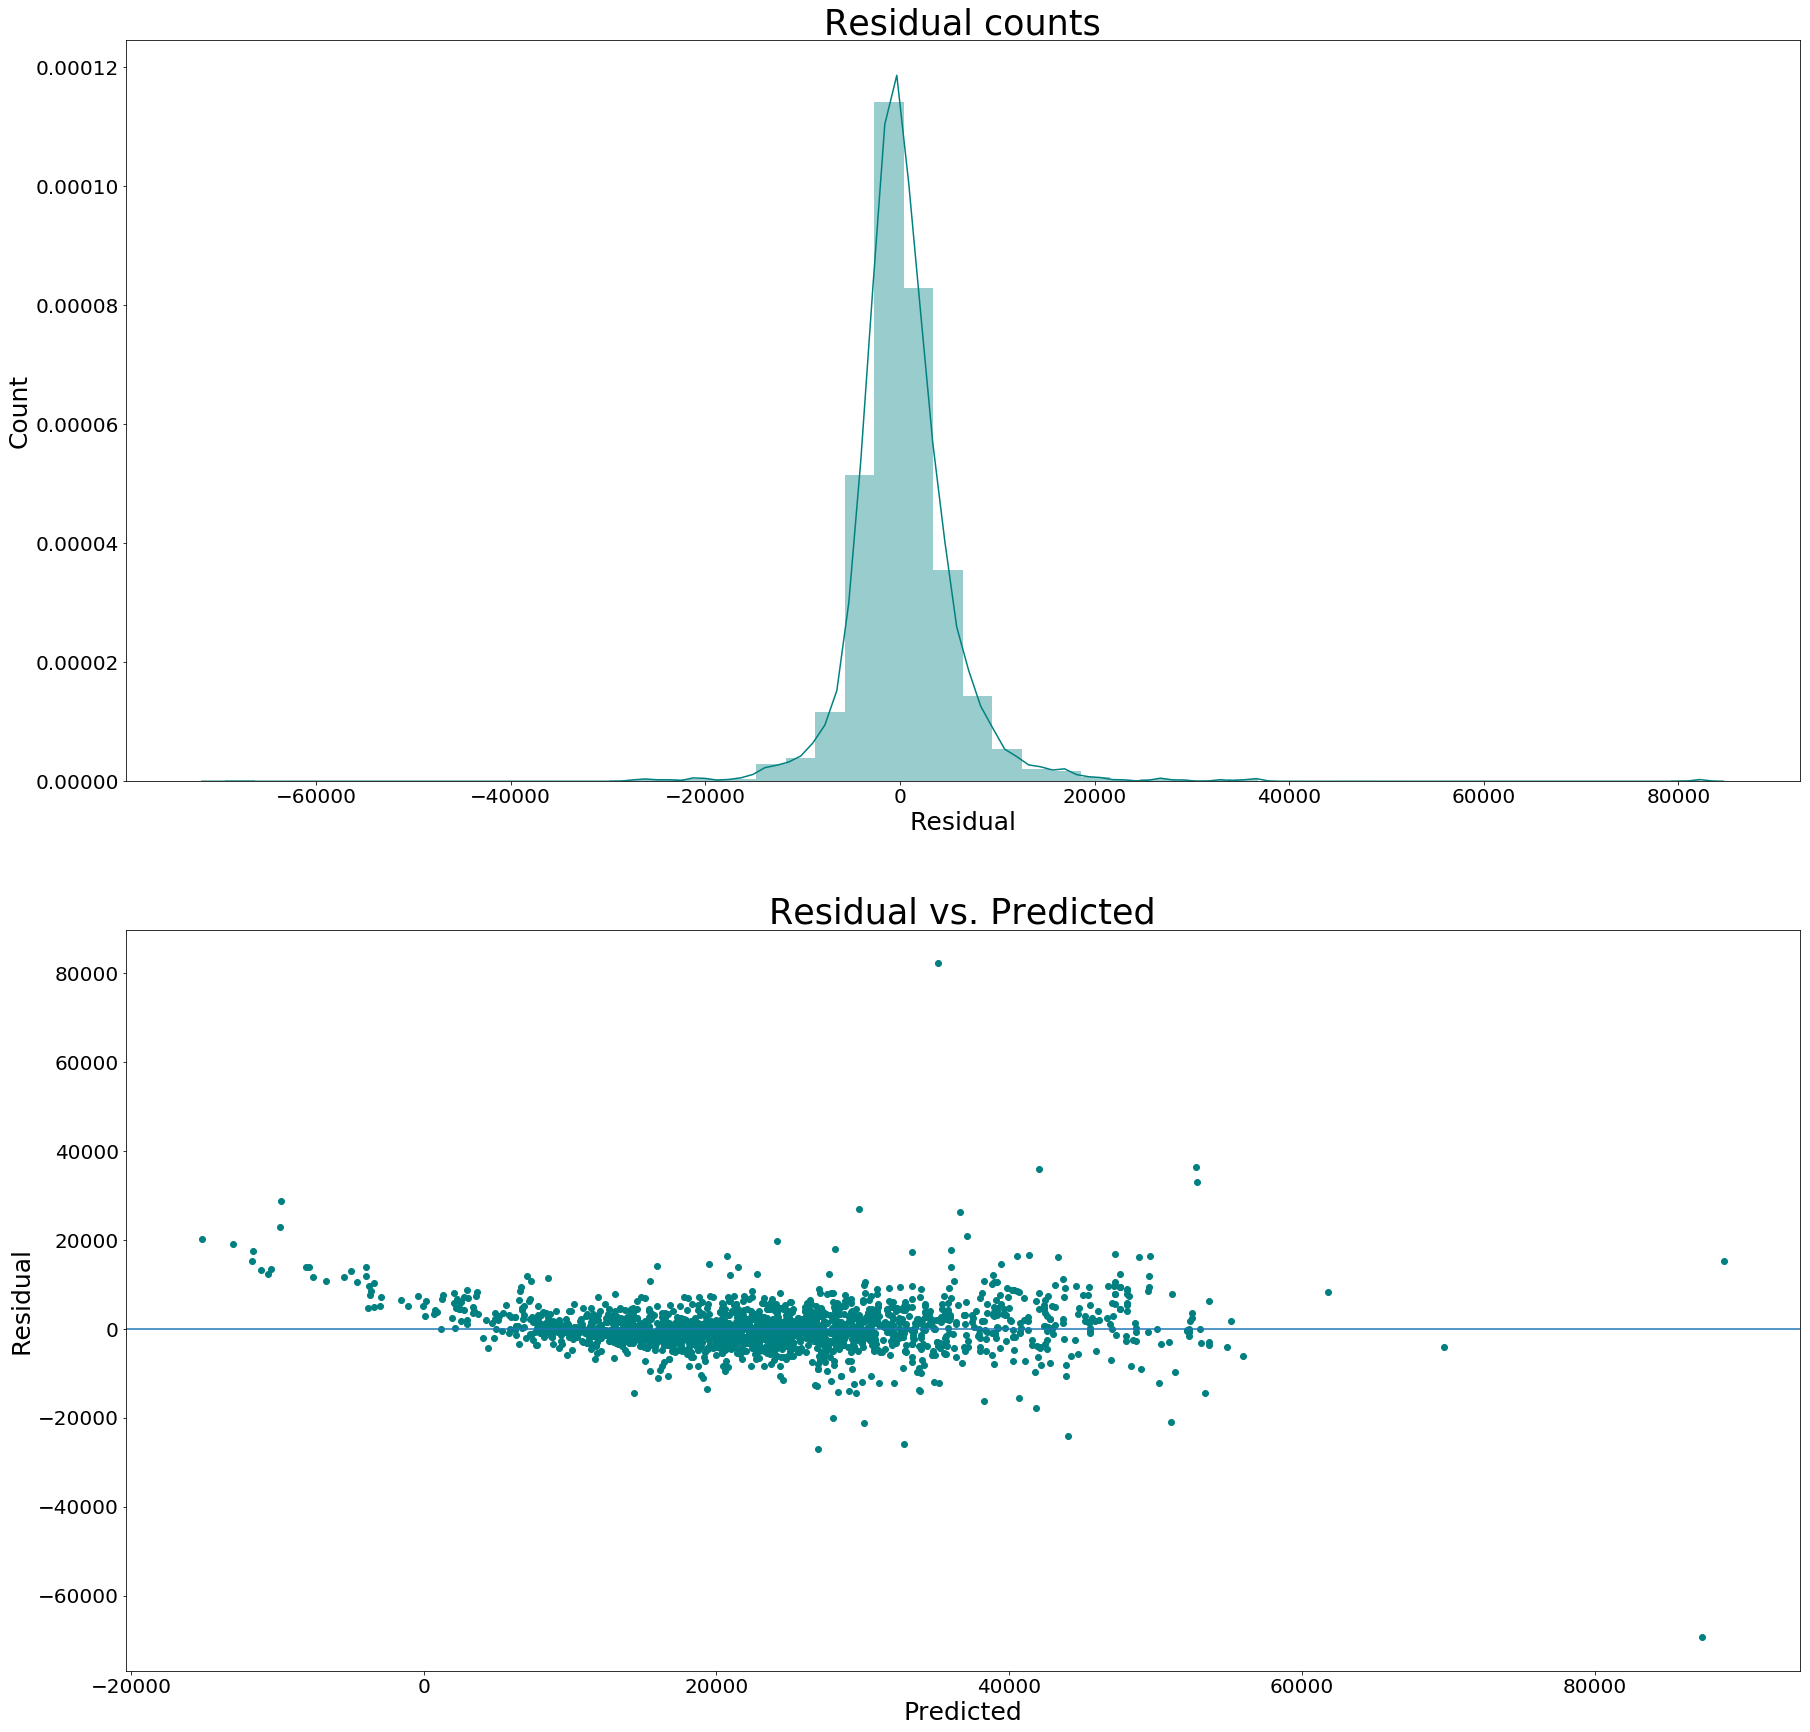

In [48]:
from sklearn import linear_model

regr = linear_model.LinearRegression()
regr.fit(X_train, Y_train)

predicted = regr.predict(X_test)
residual = Y_test - predicted

fig = plt.figure(figsize=(30,30))
ax1 = plt.subplot(211)
sns.distplot(residual, color ='teal')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Residual counts',fontsize=35)
plt.xlabel('Residual',fontsize=25)
plt.ylabel('Count',fontsize=25)

ax2 = plt.subplot(212)
plt.scatter(predicted, residual, color ='teal')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Predicted',fontsize=25)
plt.ylabel('Residual',fontsize=25)
plt.axhline(y=0)
plt.title('Residual vs. Predicted',fontsize=35)

plt.show()

In [49]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(Y_test, predicted))
print('RMSE:')
print(rmse)

print('Variance score: %.2f' % r2_score(Y_test, predicted))

RMSE:
5484.900125781087
Variance score: 0.80


## Boosting

In [50]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

r_sq = []
deep = []
mean_scores = []

#loss : {‘ls’, ‘lad’, ‘huber’, ‘quantile’}
for n in range(3, 11):
    gbr = GradientBoostingRegressor(loss ='ls', max_depth=n)
    gbr.fit (X, Y)
    deep.append(n)
    r_sq.append(gbr.score(X, Y))
    mean_scores.append(cross_val_score(gbr, X, Y, cv=12).mean())

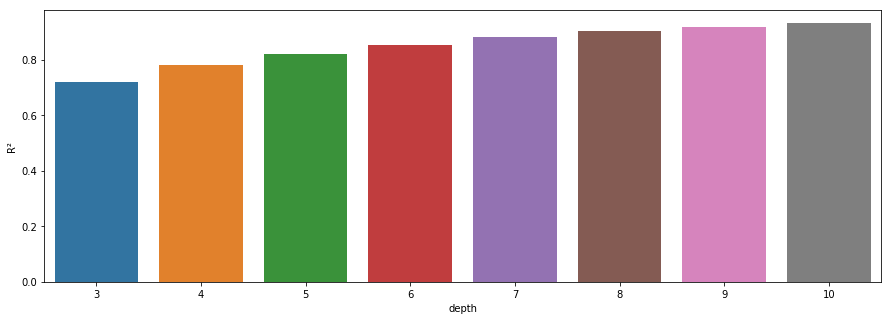

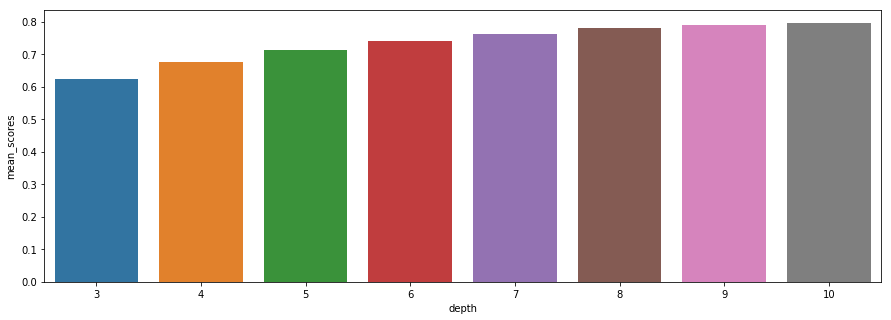

In [51]:
plt_gbr = pd.DataFrame()

plt_gbr['mean_scores'] = mean_scores
plt_gbr['depth'] = deep
plt_gbr['R²'] = r_sq

f, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data = plt_gbr, x='depth', y='R²')
plt.show()

f, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data = plt_gbr, x='depth', y='mean_scores')
plt.show()

C:\Users\julia\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


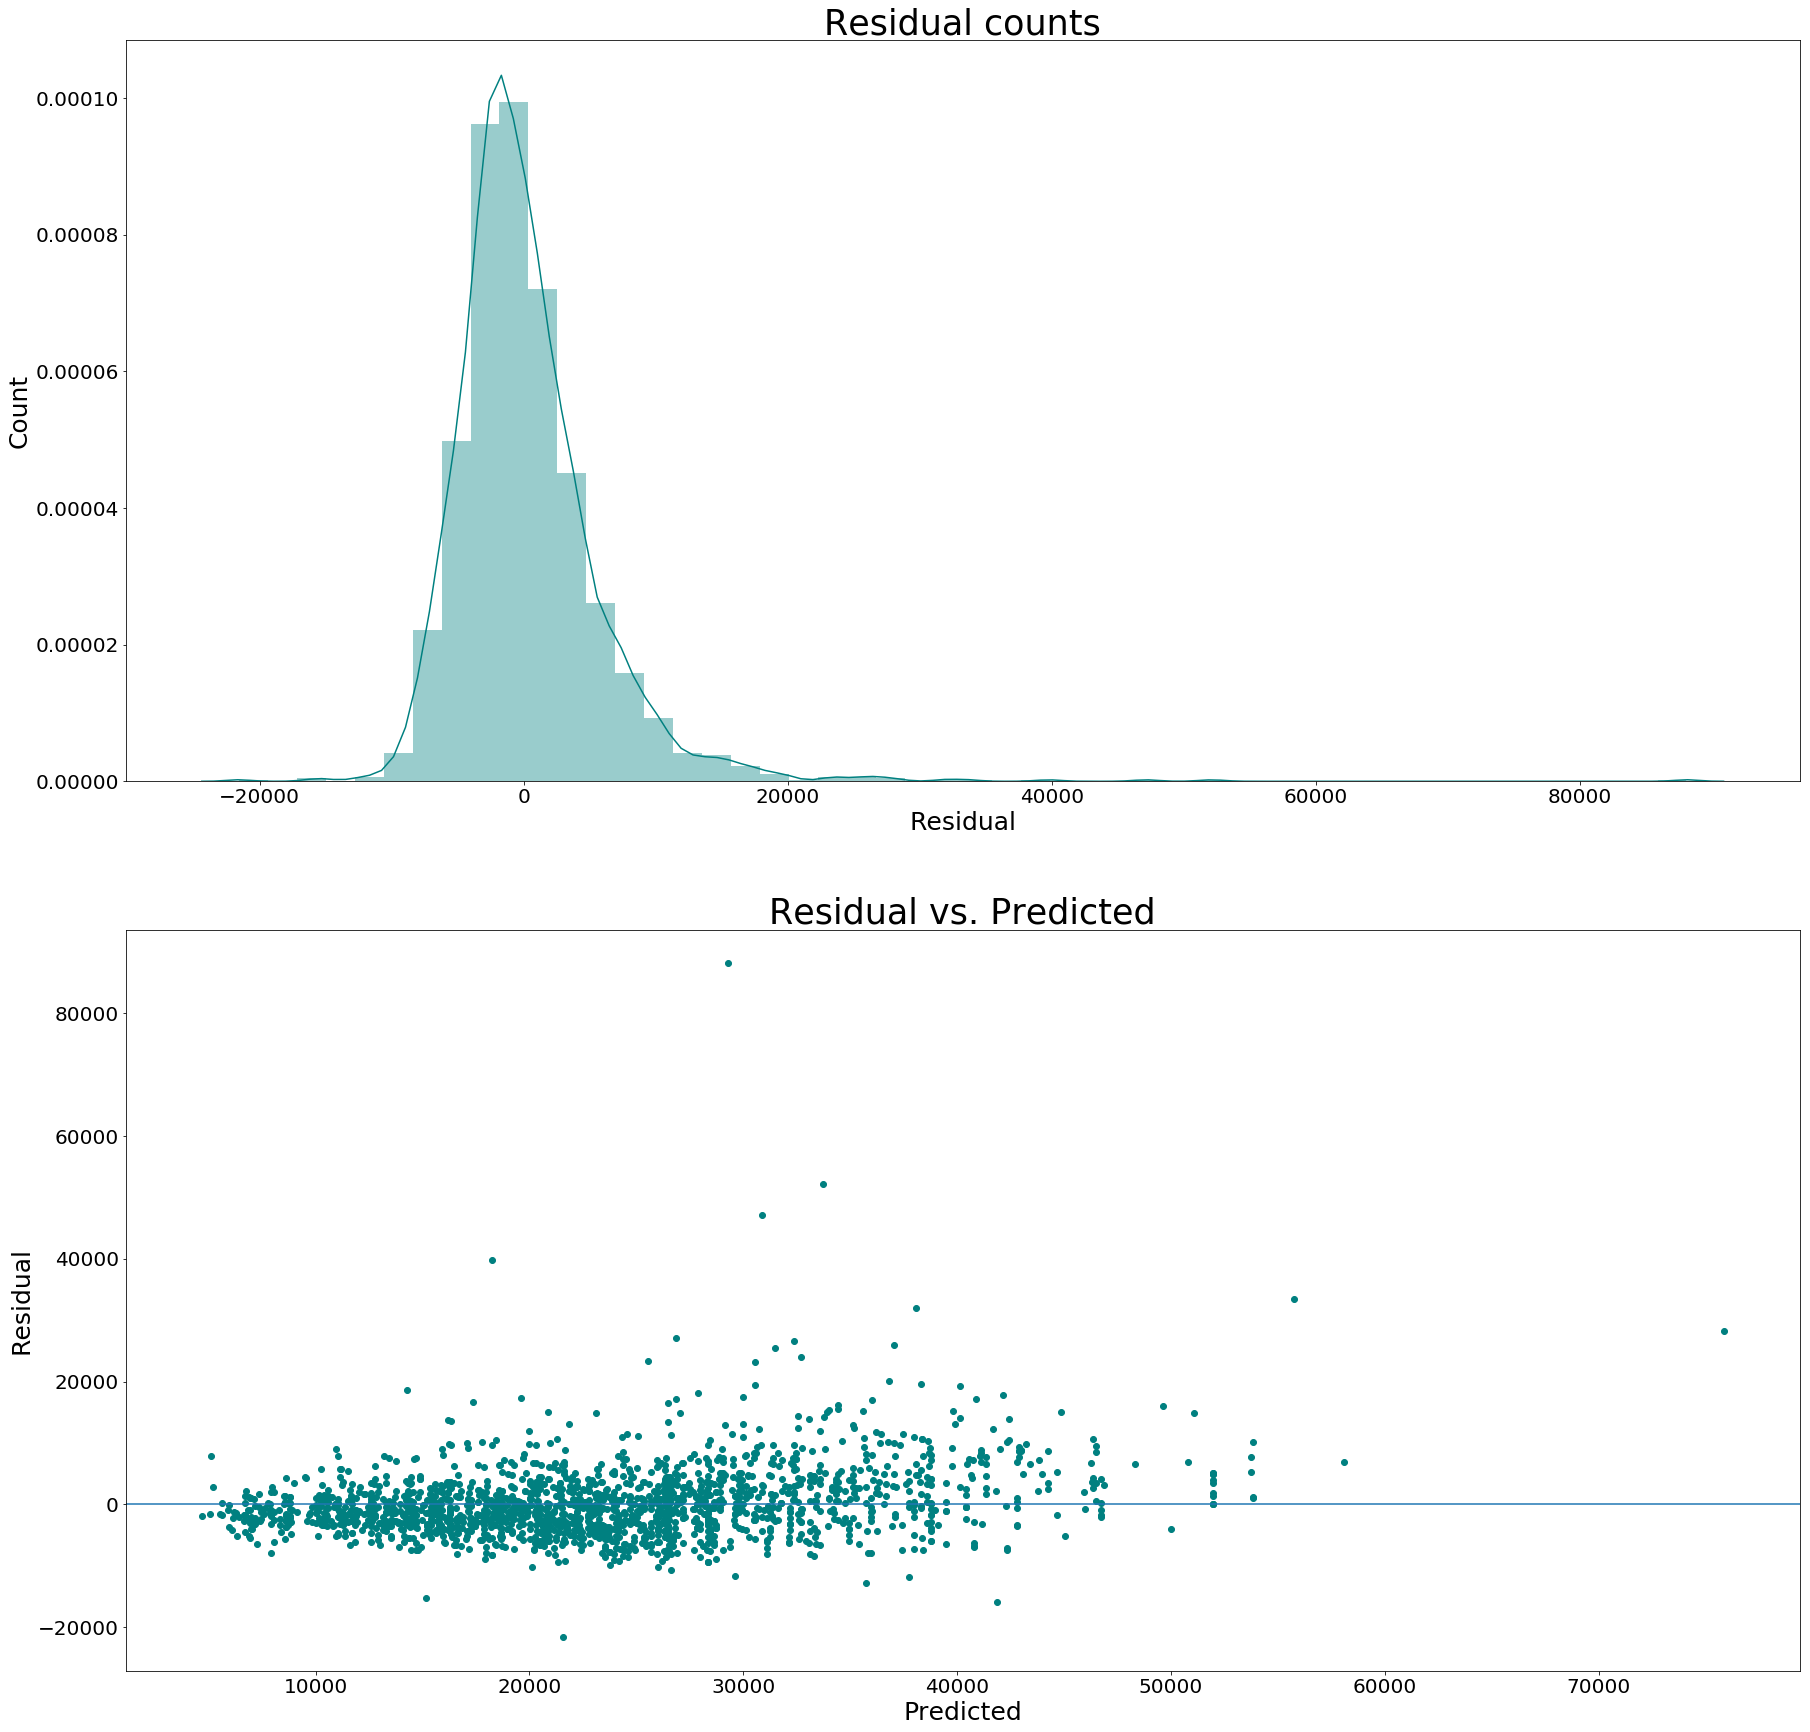

In [52]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

gbr = GradientBoostingRegressor(loss ='ls', max_depth=6)
gbr.fit (X_train, Y_train)
predicted = gbr.predict(X_test)
residual = Y_test - predicted

fig = plt.figure(figsize=(30,30))
ax1 = plt.subplot(211)
sns.distplot(residual, color ='pink')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Residual counts',fontsize=35)
plt.xlabel('Residual',fontsize=25)
plt.ylabel('Count',fontsize=25)

ax2 = plt.subplot(212)
plt.scatter(predicted, residual, color ='pink')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Predicted',fontsize=25)
plt.ylabel('Residual',fontsize=25)
plt.axhline(y=0)
plt.title('Residual vs. Predicted',fontsize=35)

plt.show()

In [59]:
print('\nCross Validation Scores:')
print(mean_scores)
print('\nMean Score:')
print(np.mean(mean_scores))  ## the mean of the mean??

print('\nRMSE:')
print(rmse)


print(np.mean(r_sq))
# print(r_sq)





Cross Validation Scores:
[0.6239600810738785, 0.6769563243450158, 0.7113451241208476, 0.7411500560477084, 0.7620948814311673, 0.7794075899254489, 0.7903032670376434, 0.7958358164308432]

Mean Score:
0.7351316425515692

RMSE:
5484.900125781087
0.8507926152753352


In [61]:
print('Variance score: %.2f' % r2_score(Y_test, predicted))

Variance score: 0.78


In [77]:
# A = Y_test.reshape(-1, 1)
# B = predicted.reshape(-1, 1)

# Series that needs reshaping
A = Y_test
A = A.values.reshape(-1,1)

# numpy.ndarray that needs reshaping
B = predicted
B= B.reshape(-1, 1)

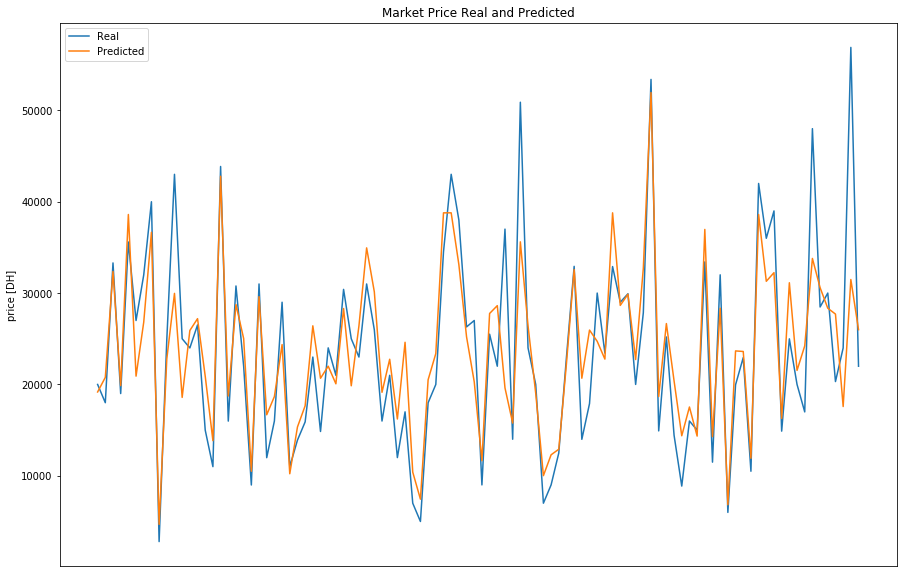

In [80]:
plt.rcParams['figure.figsize'] = 15,10
plt.figure()
plt.plot(A[-100:], label="Real")
plt.plot(B[-100:], label="Predicted")
plt.legend()
plt.title("Market Price Real and Predicted")
plt.ylabel("price [DH]")
plt.xticks(())
plt.show()

# Model Comparison

## KNN 6 Neighbors
- RMSE:5508.242817095712
- Variance score: 0.80
    
    
## KNN 15 Neighbors
- RMSE: 5944.790441454258
- Variance score: 0.77

## Decision Tree
- RMSE: 5298.616396310058
- Variance score: 0.81
    
## Linear Regression
- RMSE: 5484.900125781087
- Variance score: 0.80

## Boosting
- RMSE: 5484.900125781087
- Variance score: 0.85


Boosting has the variance score closest to 1.


In [ ]:
#this needs work below

In [178]:
user_input = {'Year':2016, 'Mileage':52000, 'Make':'Ford', 'Model':'Escape', 'Trim':'SE', 'DriveTrain': '4WD'}
def input_to_one_hot(data):
    # initialize the target vector with zero values
    enc_input = np.zeros(1586)
    
    # Handle Numeric Data
    enc_input[0] = data['Year']
    enc_input[1] = data['Mileage']
    
    # Handle Categorical Data  
    
    ##################### Make #########################
    # get the array of make categories
    makes = df.Make.unique()
    # redefine the the user inout to match the column name
    redefinded_user_input = 'Make_'+data['Make']
    # search for the index in columns name list 
    Make_column_index = X.columns.tolist().index(redefinded_user_input)
    #print(mark_column_index)
    # fullfill the found index with 1
    enc_input[Make_column_index] = 1
    
        ##################### Model #########################
    # get the array of model categories
    models = df.Model.unique()
    # redefine the the user inout to match the column name
    redefinded_user_input = 'Model_'+data['Model']
    # search for the index in columns name list 
    Model_column_index = X.columns.tolist().index(redefinded_user_input)
    #print(mark_column_index)
    # fullfill the found index with 1
    enc_input[Model_column_index] = 1
    
        ##################### Trim #########################
    # get the array of trim categories
    trims = df.Trim.unique()
    # redefine the the user inout to match the column name
    redefinded_user_input = 'Trim_'+data['Trim']
    # search for the index in columns name list 
    Trim_column_index = X.columns.tolist().index(redefinded_user_input)
    #print(mark_column_index)
    # fullfill the found index with 1
    enc_input[Trim_column_index] = 1
    
        ##################### DriveTrain #########################
    # get the array of drivetrain categories
    drivetrains = df.DriveTrain.unique()
    # redefine the the user inout to match the column name
    redefinded_user_input = 'DriveTrain_'+data['DriveTrain']
    # search for the index in columns name list 
    DriveTrain_column_index = X.columns.tolist().index(redefinded_user_input)
    #print(mark_column_index)
    # fullfill the found index with 1
    enc_input[DriveTrain_column_index] = 1
    

    
    return enc_input

In [179]:
df.head()

,ParentBusinessUnit,BusinessUnit,Latitude,Longitude,StateShort,Year,Make,Model,Trim,Mileage,...,Received,Transmission,Risk,PrimaryBookValue,class,MakeModel,YMM,DriveTrain,Doors,Class
0,Lithia Motors Inc.,Klamath Falls Toyota,42.2076,-121.7547,OR,2001,Dodge,Ram 2500,NaN,300891.0,...,3/3/2019,Manual,RED,5102.0,2WD Standard Pickup Trucks,Dodge Ram 2500,2001 Dodge Ram 2500,2WD,4-door,Standard Pickup Trucks
1,Lithia Motors Inc.,Klamath Falls Toyota,42.2076,-121.7547,OR,2016,Ford,Escape,SE,54270.0,...,1/18/2019,Automatic,YELLOW,13949.0,4WD Sport Utility Vehicles,Ford Escape,2016 Ford Escape,4WD,4-door,Sport Utility Vehicles
2,Lithia Motors Inc.,Klamath Falls Toyota,42.2076,-121.7547,OR,2013,Hyundai,Sonata,GLS PZEV,105515.0,...,12/21/2018,Automatic,RED,6859.0,4-door Mid-Size Passenger Car,Hyundai Sonata,2013 Hyundai Sonata,4WD,4-door,Mid-Size Passenger Car
3,Lithia Motors Inc.,Klamath Falls Toyota,42.2076,-121.7547,OR,2003,Subaru,Legacy,L,166770.0,...,12/31/2018,Automatic,RED,1266.0,Mid-Size Wagon,Subaru Legacy,2003 Subaru Legacy,4WD,4-door,Mid-Size Wagon
4,Lithia Motors Inc.,Klamath Falls Toyota,42.2076,-121.7547,OR,2010,GMC,Sierra 1500,SLT,121054.0,...,6/21/2018,Automatic,RED,16568.0,4WD Standard Pickup Trucks,GMC Sierra 1500,2010 GMC Sierra 1500,4WD,4-door,Standard Pickup Trucks


In [180]:
print(input_to_one_hot(user_input))

[ 2016. 52000.     0. ...     0.     0.     0.]


In [181]:
a = input_to_one_hot(user_input)

In [182]:
price_pred = gbr.predict([a])

In [153]:
price_pred

array([15353.14346974])

Save Model


In [183]:
from sklearn.externals import joblib

joblib.dump(gbr, 'model.pkl')

['model.pkl']

In [184]:
gbr = joblib.load('model.pkl')

In [185]:
print("the best price for vehicle is",gbr.predict([a])[0])

the best price for vehicle is 15353.14346973538
